In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def fgsm_attack(image, epsilon, gradient):
    adversarial_image = image + epsilon * gradient
    adversarial_image = np.clip(adversarial_image, 0, 255)
    return adversarial_image.astype(np.uint8)

zip_path = '/content/Detect_AI_Art.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

real_folder = '/content/REAL/'
fake_folder = '/content/FAKE/'

def resize_image(image_path, output_path, size):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img.save(output_path)

os.makedirs('/content/REAL_resized', exist_ok=True)
os.makedirs('/content/FAKE_resized', exist_ok=True)

for filename in os.listdir(real_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(real_folder, filename)
        output_path = os.path.join('/content/REAL_resized', filename)
        resize_image(image_path, output_path, (256, 256))

for filename in os.listdir(fake_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(fake_folder, filename)
        output_path = os.path.join('/content/FAKE_resized', filename)
        resize_image(image_path, output_path, (256, 256))

print("Image resizing completed.")

Image resizing completed.


In [1]:
def plot_adversarial_image(adversarial_images):
    plt.imshow(adversarial_images[0])  # Plotting the first adversarial image
    plt.title('Adversarial Image')
    plt.axis('off')
    plt.show()

Found 2728 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
Epoch 1/10
6/6 [==============================] - 39s 5s/step - loss: 1.4813 - accuracy: 0.5729 - val_loss: 0.8299 - val_accuracy: 0.3438
Epoch 2/10
6/6 [==============================] - 29s 5s/step - loss: 0.6750 - accuracy: 0.5625 - val_loss: 1.5136 - val_accuracy: 0.4688
Epoch 3/10
6/6 [==============================] - 29s 5s/step - loss: 0.9147 - accuracy: 0.4948 - val_loss: 0.6343 - val_accuracy: 0.6250
Epoch 4/10
6/6 [==============================] - 29s 5s/step - loss: 0.6575 - accuracy: 0.6510 - val_loss: 0.6661 - val_accuracy: 0.7188
Epoch 5/10
6/6 [==============================] - 29s 5s/step - loss: 0.6346 - accuracy: 0.7135 - val_loss: 0.6074 - val_accuracy: 0.6562
Epoch 6/10
6/6 [==============================] - 36s 6s/step - loss: 0.5881 - accuracy: 0.7344 - val_loss: 0.5261 - val_accuracy: 0.8750
Epoch 7/10
6/6 [==============================]

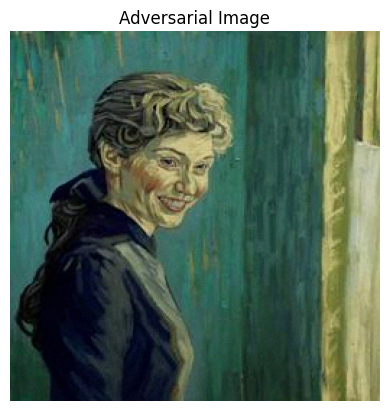

106/106 [==============================] - 139s 1s/step - loss: 0.4213 - accuracy: 0.8087
Original Test accuracy: 0.8087
106/106 [==============================] - 133s 1s/step - loss: 2.4124 - accuracy: 0.5012
Adversarial Test accuracy: 0.5012
107/107 [==============================] - 131s 1s/step


In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

resized_folder = '/content/'

img_size = (256, 256)
batch_size = 32

subset_size = 200

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=resized_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['REAL_resized', 'FAKE_resized'],
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    directory=resized_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['REAL_resized', 'FAKE_resized'],
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=resized_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['REAL_resized', 'FAKE_resized'],
    shuffle=False
)

original_images, _ = next(test_generator)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


train_steps = subset_size // batch_size
validation_steps = int(subset_size * 0.2) // batch_size

model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)


In [ ]:
adversarial_images = []
for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]

    gradients = np.random.randn(*batch_x.shape)

    epsilon = 0.01
    scaled_gradients = epsilon * np.sign(gradients)
    adversarial_batch_x = batch_x + scaled_gradients
    adversarial_batch_x = np.clip(adversarial_batch_x, 0, 1)

    adversarial_images.append(adversarial_batch_x)

adversarial_images = np.np.vstack(adversarial_images)

plot_adversarial_image(adversarial_images)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Original Test accuracy: {test_acc:.4f}')


adversarial_test_generator = test_datagen.flow(adversarial_images, test_generator.classes, batch_size=batch_size)
adv_test_loss, adv_test_acc = model.evaluate(adversarial_test_generator, steps=test_generator.samples // batch_size)
print(f'Adversarial Test accuracy: {adv_test_acc:.4f}')


test_predictions = model.predict(test_generator)
test_predictions = np.round(test_predictions).reshape(-1)
test_true_labels = test_generator.classes

adversarial_test_predictions = model.predict(adversarial_test_generator)
adversarial_test_predictions = np.round(adversarial_test_predictions).reshape(-1)

In [8]:
original_images, _ = next(test_generator)

TypeError: Invalid shape (32, 256, 256, 3) for image data

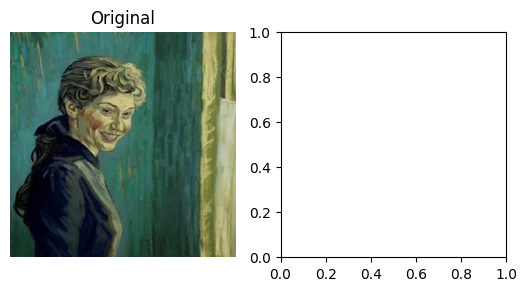

In [13]:
import matplotlib.pyplot as plt

# Choose an index for the image you want to plot
image_index = 0

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_images[image_index])
plt.title('Original')
plt.axis('off')

# Plot the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(adversarial_images[0])
plt.title('Adversarial')
plt.axis('off')

plt.show()

In [ ]:
test_predictions = model.predict(test_generator)
test_predictions = np.round(test_predictions).reshape(-1)
test_true_labels = test_generator.classes

adversarial_test_predictions = model.predict(adversarial_test_generator)
adversarial_test_predictions = np.round(adversarial_test_predictions).reshape(-1)

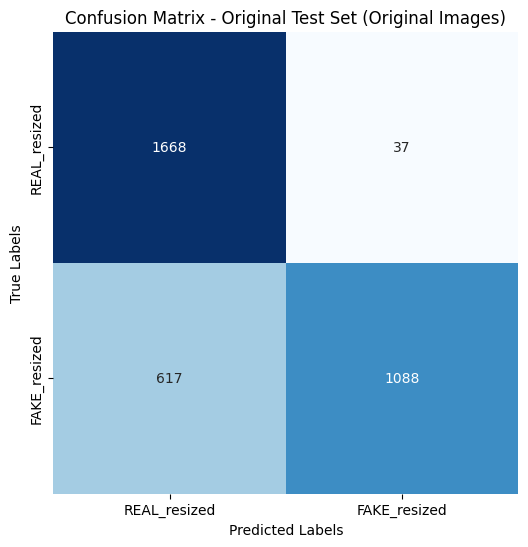

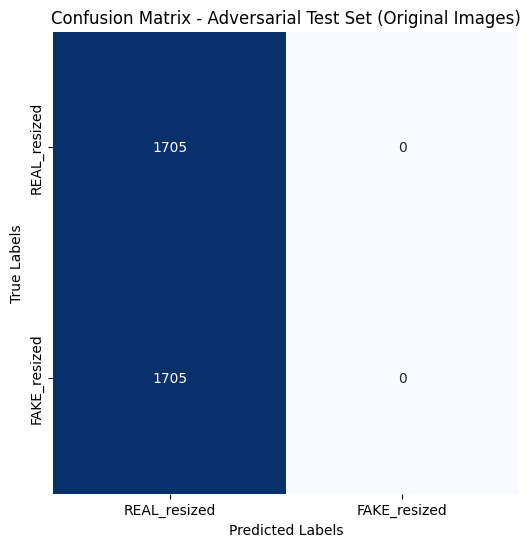

In [9]:
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Original Test Set (Original Images)')
plt.show()

adv_cm = confusion_matrix(test_true_labels, adversarial_test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(adv_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Adversarial Test Set (Original Images)')
plt.show()